#### Synthea

##### Process

In [41]:
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import classification_report

import sys
sys.path.insert(1, '../')
from utils.packages import *

def load_model(path, model):
    # load pretrained model and update weights
    pretrained_dict = torch.load(path)
    model_dict = model.state_dict()
    # 1. filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict)
    # 3. load the new state dict
    model.load_state_dict(model_dict)
    return model

global_params = {
    'max_seq_len': 64,
    'gradient_accumulation_steps': 1
}

optim_param = {
    'lr': 3e-5,
    'warmup_proportion': 0.1,
    'weight_decay': 0.01
}

train_params = {
    'batch_size': 10,
    'use_cuda': True,
    'max_len_seq': global_params['max_seq_len'],
    'device': 'cuda' #change this to run on cuda #'cuda:0'
}

dataset_name = 'Synthea/Final_cohorts/'

feature_types = {'diagnosis':True, 'medications':True, 'procedures':True}

if (feature_types['diagnosis'] and feature_types['medications'] and not (feature_types['procedures'])):
    print("Do only use diagnosis")
    code_voc = 'MLM_diagnosmedcodes.npy'
    age_voc = 'MLM_age.npy'

elif (feature_types['diagnosis'] and not feature_types['medications']):
    code_voc = 'MLM_diagnoscodes.npy'
    age_voc = 'MLM_age.npy'

else:
    code_voc = 'MLM_diagnosproccodes.npy'
    age_voc = 'MLM_age.npy'

files = {'code':'../data/vocabularies/' + dataset_name + code_voc,
             'age':'../data/vocabularies/' + dataset_name + age_voc,
        }

tokenizer = EHRTokenizer(task='MLM', filenames=files)

model_config = {
        'vocab_size': len(tokenizer.getVoc('code').keys()), # number of disease + symbols for word embedding
        'hidden_size': 288, #tune.choice([100, 150, 288]), #288, # word embedding and seg embedding hidden size
        'seg_vocab_size': 2, # number of vocab for seg embedding
        'age_vocab_size': len(tokenizer.getVoc('age').keys()), # number of vocab for age embedding,
        'gender_vocab_size': 3,
        'max_position_embeddings': train_params['max_len_seq'], # maximum number of tokens
        'hidden_dropout_prob': 0.1, # dropout rate
        'num_hidden_layers': 6, #4, # number of multi-head attention layers required
        'num_attention_heads': 12, # number of attention heads
        'attention_probs_dropout_prob': 0.1, # multi-head attention dropout rate
        'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
        'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
        'initializer_range': 0.02, # parameter weight initializer range
        'use_prior':True,
        'reg':0.1,
        'age':True,
        'gender':True,
        'epochs':20,
    }

stats_path = '../data/train_stats/Synthea/'
condfiles = {'dd':stats_path + 'dd_cond_probs.empirical.p', 
             'dp':stats_path + 'dp_cond_probs.empirical.p',
             'dm':stats_path + 'dm_cond_probs.empirical.p',
             'pp':stats_path + 'pp_cond_probs.empirical.p', 
             'pd':stats_path + 'pd_cond_probs.empirical.p',
             'pm':stats_path + 'pd_cond_probs.empirical.p',
             'mm':stats_path + 'mm_cond_probs.empirical.p', 
             'md':stats_path + 'md_cond_probs.empirical.p',
             'mp':stats_path + 'mp_cond_probs.empirical.p',
            }

In [2]:
path='../data/datasets/' + dataset_name
path

'../data/datasets/Synthea/Final_cohorts/'

In [3]:
test = pd.read_parquet(path + 'train.parquet')
#val = pd.read_parquet(path + 'val.parquet')
#test = pd.read_parquet(path + 'test.parquet')
#all_data = pd.concat([train, val, test])

In [4]:
diagnosmap = pd.read_csv('../data/mapping_data/Synthea/unique_conds.csv')
diagnosmap['CODE'] = diagnosmap['CODE'].map(str)

medmap = pd.read_csv('../data/mapping_data/Synthea/synthea_medication_description.csv').rename(columns={'Unnamed: 0':'CODE', '0':'DESCRIPTION'})
medmap['CODE'] = medmap['CODE'].map(str)

procmap = pd.read_csv('../data/mapping_data/Synthea/synthea_procedure_description.csv').rename(columns={'Unnamed: 0':'CODE', '0':'DESCRIPTION'})
procmap['CODE'] = procmap['CODE'].map(str)


In [5]:
diagnosmapdict = dict(zip(diagnosmap.CODE,diagnosmap.DESCRIPTION))
medmapdict = dict(zip(medmap.CODE,medmap.DESCRIPTION))
procmapdict = dict(zip(procmap.CODE,procmap.DESCRIPTION))

In [6]:
hypertensioncode = int(diagnosmap[diagnosmap['DESCRIPTION'].isin(['Hypertension', 'hypertension'])]['CODE'].iloc[0])
test['diagnos_flatten'] = test['diagnos_code'].apply(lambda x: np.concatenate(x))
test['hypercode'] = test['diagnos_flatten'].apply(lambda x: True if hypertensioncode in x else False)
hypertensionpatients = test[test['hypercode'] == True]

In [7]:
folderpath = '../data/pytorch_datasets/' + dataset_name
hypertensionpatientsdataset = EHRDataset(hypertensionpatients, max_len=train_params['max_len_seq'], run_type='Hypertension_synthea', save_folder=folderpath,feature_types=feature_types, conditional_files=condfiles, tokenizer=tokenizer)
hypertensionloader = torch.utils.data.DataLoader(hypertensionpatientsdataset, batch_size=1, pin_memory=True, shuffle=False)

Use diagnosis: True
Use medications: True
Use procedures: True
Loading data


In [42]:
conf = BertConfig(model_config)
model = BertForMaskedLM(conf)
#PATH = "../saved_models/MLM/BEHRT_+p+m_synthea"
PATH = "../saved_models/MLM/CondBEHRT_synthea"
model = load_model(PATH, model)
params = list(model.named_parameters())
optim = adam(params, optim_param)

t_total value of -1 results in schedule not being applied


##### Attention

###### Example

In [9]:
iterr = iter(hypertensionloader)

In [ ]:
datapoint = next(iterr)

In [43]:
with torch.no_grad():
    model.eval()
    age, gender, code, position, segment, mask, label, prior_guide, tokens = datapoint

    loss, preds, labels, attention_scores, sequence_outputs = model(code, age_ids=age, gender_ids=gender, seg_ids=segment, posi_ids=position, attention_mask=mask, labels=label, prior_guide=prior_guide)
    sentence = tokenizer.convert_ids_to_tokens(code.numpy().squeeze(), 'code')
    lastatt = attention_scores[-1]
    firstatt = attention_scores[0]
    averagedlastatt = ((lastatt.sum(dim=1) / lastatt.shape[1])[0]).detach().numpy()

In [44]:
firstatt.shape

torch.Size([1, 12, 64, 64])

In [45]:
avgheads = ((firstatt.sum(dim=1) / firstatt.shape[1])[0]).detach().numpy()

In [46]:
#tokenizer.convert_ids_to_tokens(code.numpy().squeeze(), 'code')

In [47]:
sentence_conv = []
    
for s in sentence:
    if s == '[CLS]' or s == '[SEP]' or s == '[MASK]':
        sentence_conv.append(s)
        continue

    if s =='[PAD]':
        #sentence_conv.append(s)
        continue

    if s in diagnosmapdict:
        sentence_conv.append(diagnosmapdict[s])

    elif s in medmapdict:
        sentence_conv.append(medmapdict[s])

    elif s in procmapdict:
        sentence_conv.append(procmapdict[s])
    else:
        sentence_conv.append(s)

In [48]:
dm_path = condfiles['dd'] # diagnose-medication
dm = pickle.load(open(dm_path, 'rb'))

In [49]:
#lin10 = 314076
hypertenscode = 59621000
code2 = 105531004

<Figure size 1944x1944 with 0 Axes>

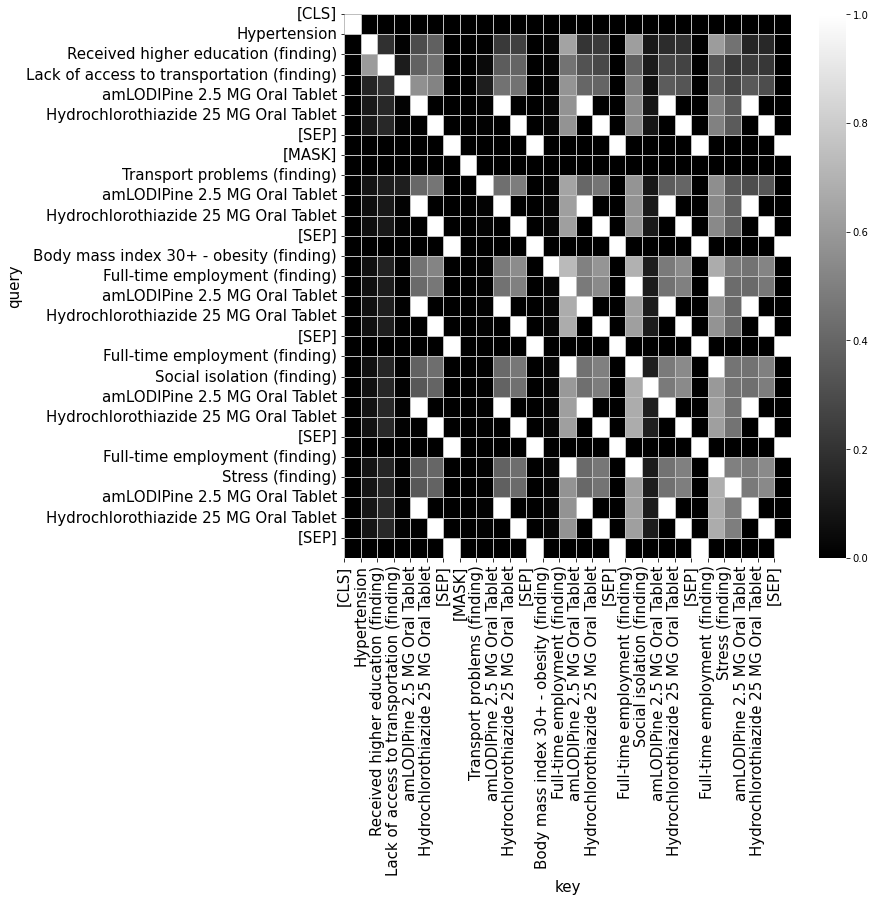

In [50]:
f, ax = plt.subplots(figsize = (len(sentence_conv),len(sentence_conv)))
map1 = avgheads[:len(sentence_conv), :len(sentence_conv)]
plt.clf()
f=plt.figure(figsize=(10,10))
ax = f.add_subplot(1,1,1)
#i=ax.imshow(map1,interpolation='nearest',cmap='gray')
sns.heatmap(map1, annot=False, linewidths=1, fmt="f", ax=ax, xticklabels = sentence_conv, yticklabels = sentence_conv, cmap="gray")
ax.set_yticks(range(len(sentence_conv)))
ax.set_yticklabels(sentence_conv, fontsize=15)
ax.set_xticks(range(len(sentence_conv)))
ax.set_xticklabels(sentence_conv,rotation=90, fontsize=15)
ax.set_xlabel('key', fontsize=15)
ax.set_ylabel('query', fontsize=15)
ax.grid(linewidth = 0.8)

<Figure size 3168x3168 with 0 Axes>

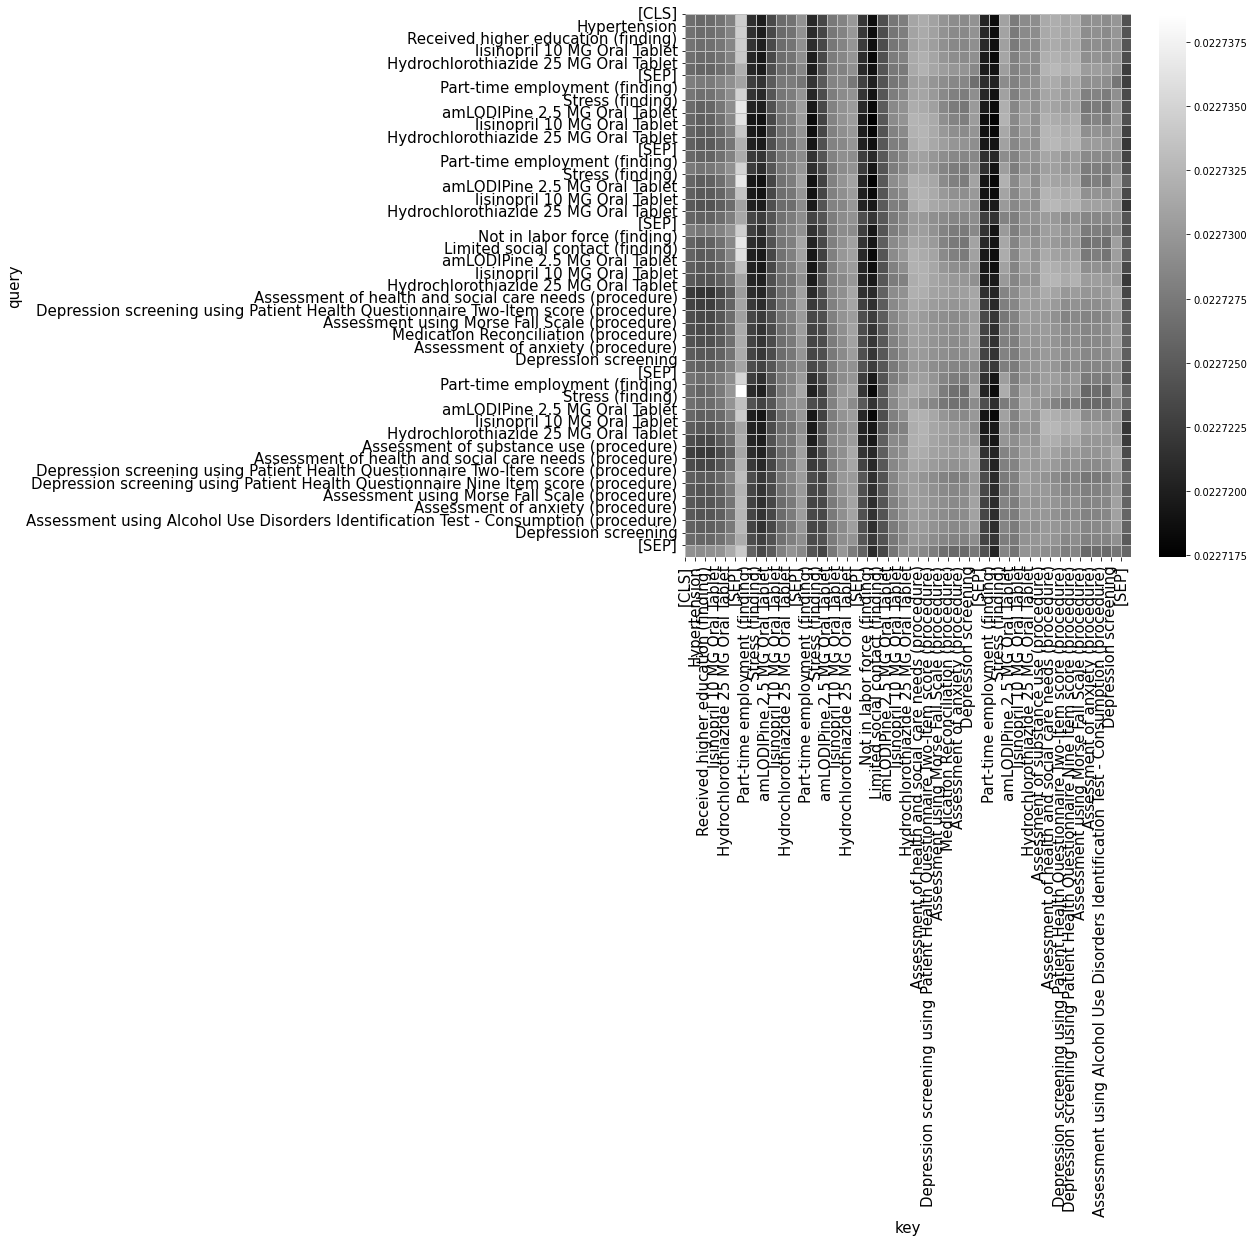

In [142]:
f, ax = plt.subplots(figsize = (len(sentence_conv),len(sentence_conv)))
map1 = lastatt[0][1].detach().numpy() #((layer.sum(dim=1) / layer.shape[1])[0]).detach().numpy()
map1 = map1[:len(sentence_conv), :len(sentence_conv)]
#print(map1)
plt.clf()
f=plt.figure(figsize=(10,10))
ax = f.add_subplot(1,1,1)
#i=ax.imshow(map1,interpolation='nearest',cmap='gray')
sns.heatmap(map1, annot=False, linewidths=1, fmt="f", ax=ax, xticklabels = sentence_conv, yticklabels = sentence_conv, vmax=map1.max(), vmin=map1.min(), cmap='gray')
ax.set_yticks(range(len(sentence_conv)))
ax.set_yticklabels(sentence_conv, fontsize=15)
ax.set_xticks(range(len(sentence_conv)))
ax.set_xticklabels(sentence_conv,rotation=90, fontsize=15)
ax.set_xlabel('key', fontsize=15)
ax.set_ylabel('query', fontsize=15)
ax.grid(linewidth = 0.8)

###### Average

In [468]:
token_combs = {}
with torch.no_grad():
    model.eval()
    for idx, batch in enumerate(hypertensionloader):
        if idx == 5:
            break
        age, gender, code, position, segment, mask, label, prior_guide, tokens = batch
        loss, preds, labels, attention_scores, sequence_outputs = model(code, age_ids=age, gender_ids=gender, seg_ids=segment, posi_ids=position, attention_mask=mask, labels=label, prior_guide=prior_guide)
        sentence = tokenizer.convert_ids_to_tokens(tokens.numpy().squeeze(), 'code')
        seq_out = sequence_outputs[-1]
        lastattentionscores = attention_scores[-1]
        
        averagedheads = (lastattentionscores.sum(dim=1) / lastattentionscores.shape[1])[0]
        
        dontlookattokens = set(['[CLS]', '[SEP]', '[PAD]'])
        for idx1, token1 in enumerate(sentence):
            if token1 in dontlookattokens:
                continue
            for idx2, token2 in enumerate(sentence):
                if token2 in dontlookattokens:
                    continue
                comb = token1 + ',' + token2
                prob = averagedheads[idx1, idx2]
                if comb not in token_combs:
                    token_combs[comb] = (prob.item(), 1)
                else:
                    new_prob = prob.item() + token_combs[comb][0]
                    numtimes = token_combs[comb][1] + 1
                    token_combs[comb] = (new_prob, numtimes)
        #seq = torch.cat((seq, seq_out), 0)

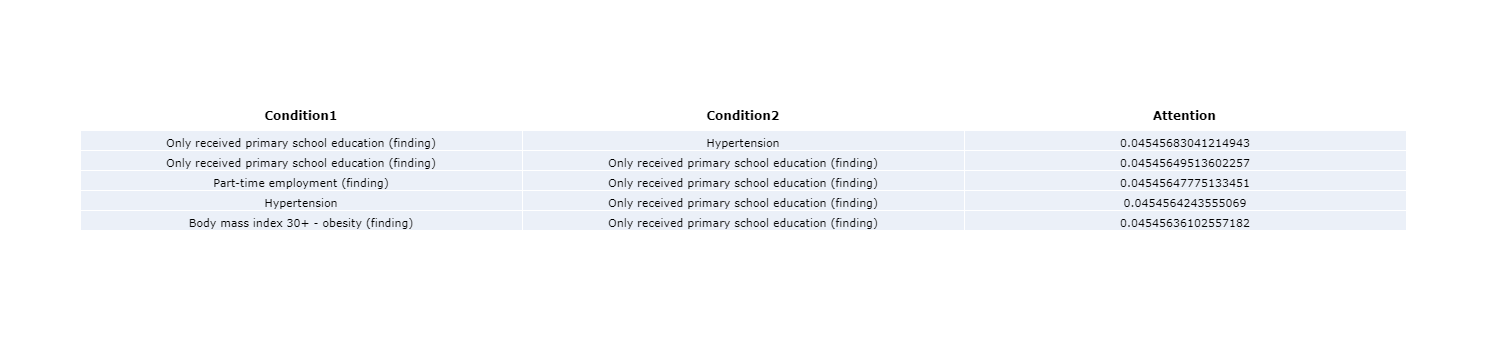

In [466]:
from operator import itemgetter
finalcombs = dict([(k, v / n) for k, (v, n) in token_combs.items()])
N = 5
res = dict(sorted(finalcombs.items(), key = itemgetter(1), reverse = True)[:N])

newrep = {'Condition1':[], 'Condition2':[], 'Attention': []}
for key, prob in res.items():
    code1, code2 = key.split(',')
    
    if code1 in diagnosmapdict:
        code1desc = diagnosmapdict[code1]
    elif code1 in medmapdict:
        code1desc = medmapdict[code1]
    else:
      #  print(code1)
        code1desc = procmapdict[code1]
    
    if code2 in diagnosmapdict:
        code2desc = diagnosmapdict[code2]
    elif code2 in medmapdict:
        code2desc = medmapdict[code2]
    else:
        code2desc = procmapdict[int(code2)]
        
    newrep['Condition1'].append(code1desc)
    newrep['Condition2'].append(code2desc)
    newrep['Attention'].append(prob)
df = pd.DataFrame(newrep)
fig = go.Figure(data=[go.Table(
  header=dict(
    values=["<b>Condition1</b>", "<b>Condition2</b>", "<b>Attention</b>"],
    line_color='white', fill_color='white',
    align='center', font=dict(color='black', size=12)
  ),
  cells=dict(
    values=[df.Condition1, df.Condition2, df.Attention],
    align='center', font=dict(color='black', size=11)
  ))
])

fig.show()

#### MIMIC

##### Processing

In [18]:
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import classification_report

import sys
sys.path.insert(1, '../')
from utils.packages import *

def load_model(path, model):
    # load pretrained model and update weights
    pretrained_dict = torch.load(path)
    model_dict = model.state_dict()
    # 1. filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict)
    # 3. load the new state dict
    model.load_state_dict(model_dict)
    return model

global_params = {
    'max_seq_len': 64,
    'gradient_accumulation_steps': 1
}

optim_param = {
    'lr': 3e-5,
    'warmup_proportion': 0.1,
    'weight_decay': 0.01
}

train_params = {
    'batch_size': 10,
    'use_cuda': True,
    'max_len_seq': global_params['max_seq_len'],
    'device': 'cuda' #change this to run on cuda #'cuda:0'
}

dataset_name = 'MIMIC/'

feature_types = {'diagnosis':True, 'medications':True, 'procedures':True}

if (feature_types['diagnosis'] and feature_types['medications'] and not (feature_types['procedures'])):
    print("Do only use diagnosis")
    code_voc = 'MLM_diagnosmedcodes.npy'
    age_voc = 'MLM_age.npy'

elif (feature_types['diagnosis'] and not feature_types['medications']):
    code_voc = 'MLM_diagnoscodes.npy'
    age_voc = 'MLM_age.npy'

else:
    code_voc = 'MLM_diagnosproccodes.npy'
    age_voc = 'MLM_age.npy'

files = {'code':'../data/vocabularies/' + dataset_name + code_voc,
             'age':'../data/vocabularies/' + dataset_name + age_voc,
        }

tokenizer = EHRTokenizer(task='MLM', filenames=files)

model_config = {
        'vocab_size': len(tokenizer.getVoc('code').keys()), # number of disease + symbols for word embedding
        'hidden_size': 288, #tune.choice([100, 150, 288]), #288, # word embedding and seg embedding hidden size
        'seg_vocab_size': 2, # number of vocab for seg embedding
        'age_vocab_size': len(tokenizer.getVoc('age').keys()), # number of vocab for age embedding,
        'gender_vocab_size': 3,
        'max_position_embeddings': train_params['max_len_seq'], # maximum number of tokens
        'hidden_dropout_prob': 0.1, # dropout rate
        'num_hidden_layers': 6, #4, # number of multi-head attention layers required
        'num_attention_heads': 12, # number of attention heads
        'attention_probs_dropout_prob': 0.1, # multi-head attention dropout rate
        'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
        'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
        'initializer_range': 0.02, # parameter weight initializer range
        'use_prior':False,
        'reg':0.1,
        'age':True,
        'gender':False,
        'epochs':20,
    }

stats_path = '../data/train_stats/MIMIC2/'
condfiles = {'dd':stats_path + 'dd_cond_probs.empirical.p', 
             'dp':stats_path + 'dp_cond_probs.empirical.p',
             'dm':stats_path + 'dm_cond_probs.empirical.p',
             'pp':stats_path + 'pp_cond_probs.empirical.p', 
             'pd':stats_path + 'pd_cond_probs.empirical.p',
             'pm':stats_path + 'pd_cond_probs.empirical.p',
             'mm':stats_path + 'mm_cond_probs.empirical.p', 
             'md':stats_path + 'md_cond_probs.empirical.p',
             'mp':stats_path + 'mp_cond_probs.empirical.p',
            }

In [2]:
path='../data/datasets/' + dataset_name
path

'../data/datasets/MIMIC/'

In [3]:
#train = pd.read_parquet(path + 'train.parquet')
#val = pd.read_parquet(path + 'val.parquet')
test = pd.read_parquet(path + 'train.parquet')
#all_dataMIMIC = pd.concat([train, val, test])

In [4]:
mimicdiagcodes = pd.read_excel("../data/mapping_data/MIMIC/findccsrcodes.xlsx", 'CCSR_Categories').rename(columns={'Searchable list of CCSR categories, v2022.1':'CODE', 'Unnamed: 1':'DESCRIPTION'})
mimicdiagcodes['CODE'] = mimicdiagcodes['CODE'].apply(lambda x: str(x))

mimicmeds = pd.read_csv("../data/mapping_data/MIMIC/ndc_descriptions.csv").rename(columns={'Unnamed: 0':'CODE', '0':'DESCRIPTION'})
mimicmeds['CODE'] = mimicmeds['CODE'].apply(lambda x: int(x))

mimicprocs = pd.read_csv("../data/mapping_data/MIMIC/PRCCSR.CSV").rename(columns={"'PRCCSR'":'CODE', "'PRCCSR DESCRIPTION'":'DESCRIPTION'})
mimicprocs['CODE'] = mimicprocs['CODE'].apply(lambda x: str(x.replace("'", "")))

In [5]:
mimicdiagcodesdict = dict(zip(mimicdiagcodes.CODE,mimicdiagcodes.DESCRIPTION))
mimicmedsdict = dict(zip(mimicmeds.CODE,mimicmeds.DESCRIPTION))
mimicprocdict = dict(zip(mimicprocs.CODE,mimicprocs.DESCRIPTION))

In [6]:
mimichypercodes = mimicdiagcodes[mimicdiagcodes['DESCRIPTION'].str.contains('Hypertension|hypertension')]['CODE'].tolist()

In [7]:
test['diag_flatten'] = test['diagnos_code'].apply(lambda x: np.concatenate(x))
test['hypercode'] = test['diag_flatten'].apply(lambda x: True if [xx for xx in x if xx in mimichypercodes ] != [] else False)
hypertensionpatientsMIMIC = test[(test['hypercode'] == True)]

In [8]:
folderpath = '../data/pytorch_datasets/' + dataset_name
mimicdataset = EHRDataset(hypertensionpatientsMIMIC, max_len=train_params['max_len_seq'], run_type='Hypertension_MIMIC', save_folder=folderpath,feature_types=feature_types, conditional_files=condfiles, tokenizer=tokenizer)
mimicloader = torch.utils.data.DataLoader(mimicdataset, batch_size=1, pin_memory=True, shuffle=True)

Use diagnosis: True
Use medications: True
Use procedures: True
Transforming data
Saving data


In [20]:
conf = BertConfig(model_config)
model = BertForMaskedLM(conf)
PATH = "../saved_models/MLM/BEHRT_+p+m_mimic"
model = load_model(PATH, model)
params = list(model.named_parameters())
optim = adam(params, optim_param)

t_total value of -1 results in schedule not being applied


##### Example

In [10]:
iterr = iter(mimicloader)

In [ ]:
datapoint = next(iterr)

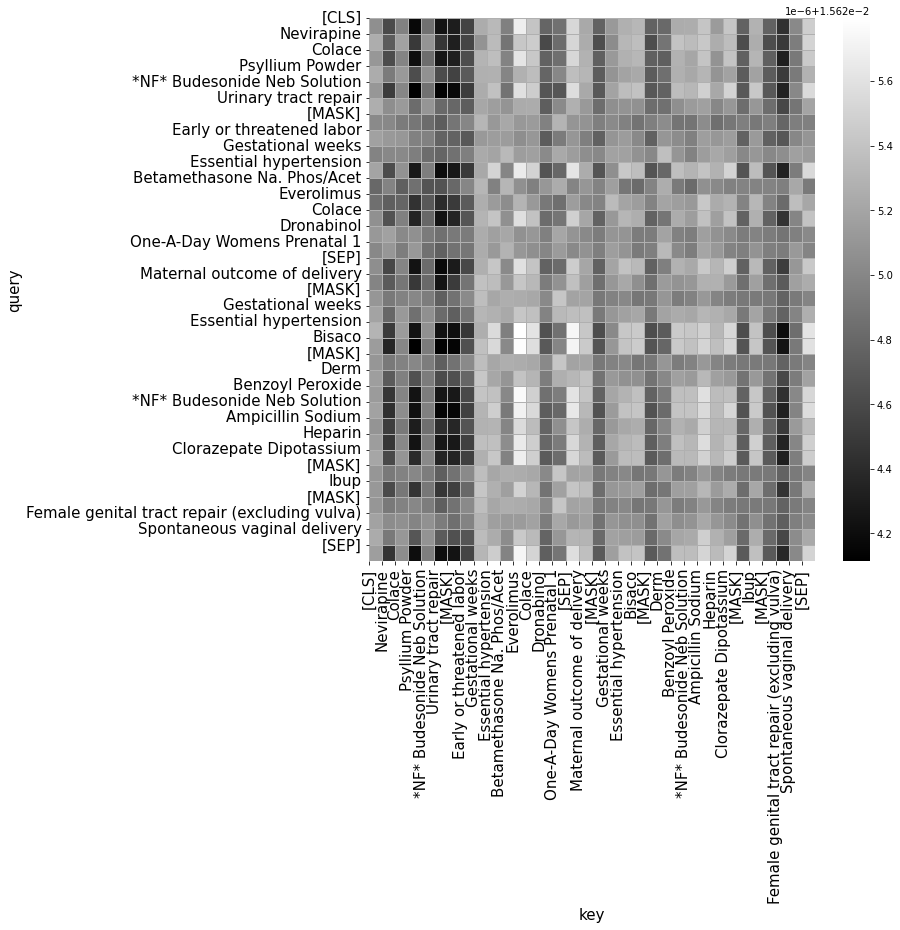

In [21]:
with torch.no_grad():
    model.eval()
    age, gender, code, position, segment, mask, label, prior_guide, tokens = datapoint

    loss, preds, labels, attention_scores, sequence_outputs = model(code, age_ids=age, gender_ids=gender, seg_ids=segment, posi_ids=position, attention_mask=mask, labels=label, prior_guide=prior_guide)
    sentence = tokenizer.convert_ids_to_tokens(code.numpy().squeeze(), 'code')
    lastatt = attention_scores[-1]
    firstatt = attention_scores[0]
    averagedlastatt = ((lastatt.sum(dim=1) / lastatt.shape[1])[0]).detach().numpy()
    avgheads = ((firstatt.sum(dim=1) / firstatt.shape[1])[0]).detach().numpy()
    
    averagedlastatt = avgheads
    sentence_conv = []
    vistn = 1
    
    for s in sentence:
        
        if s == '[SEP]':
            vistn+=1
            sentence_conv.append(s)
            continue
        if vistn == 3:
            break
            
        if s == '[CLS]' or s == '[SEP]' or s == '[MASK]':
            sentence_conv.append(s)
            continue
        
        if s =='[PAD]':
            #sentence_conv.append(s)
            continue
            
        if s in mimicdiagcodesdict:
            sentence_conv.append(mimicdiagcodesdict[s])
            
        elif s in mimicprocdict:
            sentence_conv.append(mimicprocdict[s])
            
        elif int(s) in mimicmedsdict:
            sentence_conv.append(mimicmedsdict[int(s)])
        else:
            sentence_conv.append(s)
            
f, ax = plt.subplots(figsize = (10,10))
map1 = averagedlastatt #lastatt[0][1].detach().numpy() #((layer.sum(dim=1) / layer.shape[1])[0]).detach().numpy()
map1 = map1[:len(sentence_conv), :len(sentence_conv)]
plt.clf()
ax = f.add_subplot(1,1,1)
#i=ax.imshow(map1,interpolation='nearest',cmap='gray')
sns.heatmap(map1, annot=False, linewidths=1, fmt="f", ax=ax, xticklabels = sentence_conv, yticklabels = sentence_conv, vmax=map1.max(), vmin=map1.min(), cmap='gray')
ax.set_yticks(range(len(sentence_conv)))
ax.set_yticklabels(sentence_conv, fontsize=15)
ax.set_xticks(range(len(sentence_conv)))
ax.set_xticklabels(sentence_conv,rotation=90, fontsize=15)
ax.set_xlabel('key', fontsize=15)
ax.set_ylabel('query', fontsize=15)
ax.grid(linewidth = 1)

##### Average Attentions

In [405]:
token_combs = {}
with torch.no_grad():
    model.eval()
    for idx, batch in enumerate(mimicloader):
        #if idx == 5000:
         #   break
        age, gender, code, position, segment, mask, label, prior_guide, tokens = batch
        loss, preds, labels, attention_scores, sequence_outputs = model(code, age_ids=age, gender_ids=gender, seg_ids=segment, posi_ids=position, attention_mask=mask, labels=label, prior_guide=prior_guide)
        sentence = tokenizer.convert_ids_to_tokens(tokens.numpy().squeeze(), 'code')
        seq_out = sequence_outputs[-1]
        lastattentionscores = attention_scores[-1]
        
        averagedheads = (lastattentionscores.sum(dim=1) / lastattentionscores.shape[1])[0]
        
        dontlookattokens = set(['[CLS]', '[SEP]', '[PAD]'])
        for idx1, token1 in enumerate(sentence):
            if token1 in dontlookattokens:
                continue
            for idx2, token2 in enumerate(sentence):
                if token2 in dontlookattokens:
                    continue
                comb = token1 + ',' + token2
                prob = averagedheads[idx1, idx2]
                if comb not in token_combs:
                    token_combs[comb] = (prob.item(), 1)
                else:
                    new_prob = prob.item() + token_combs[comb][0]
                    numtimes = token_combs[comb][1] + 1
                    token_combs[comb] = (new_prob, numtimes)
        #seq = torch.cat((seq, seq_out), 0)

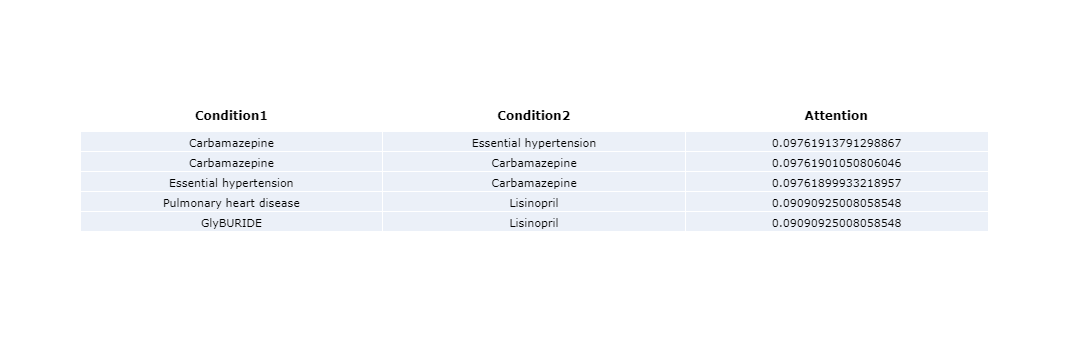

In [411]:
from operator import itemgetter
finalcombs = dict([(k, v / n) for k, (v, n) in token_combs.items()])
N = 5
res = dict(sorted(finalcombs.items(), key = itemgetter(1), reverse = True)[:N])

newrep = {'Condition1':[], 'Condition2':[], 'Attention': []}
for key, prob in res.items():
    code1, code2 = key.split(',')
    
    if code1 in mimicdiagcodesdict:
        code1desc = mimicdiagcodesdict[code1]
    elif code1 in mimicprocdict:
        code1desc = mimicdiagcodesdict[code1]
    else:
      #  print(code1)
        code1desc = mimicmedsdict[int(code1)]
    
    if code2 in mimicdiagcodesdict:
        code2desc = mimicdiagcodesdict[code2]
    elif code2 in mimicprocdict:
        code2desc = mimicdiagcodesdict[code2]
    else:
        code2desc = mimicmedsdict[int(code2)]
        
    newrep['Condition1'].append(code1desc)
    newrep['Condition2'].append(code2desc)
    newrep['Attention'].append(prob)
df = pd.DataFrame(newrep)
fig = go.Figure(data=[go.Table(
  header=dict(
    values=["<b>Condition1</b>", "<b>Condition2</b>", "<b>Attention</b>"],
    line_color='white', fill_color='white',
    align='center', font=dict(color='black', size=12)
  ),
  cells=dict(
    values=[df.Condition1, df.Condition2, df.Attention],
    align='center', font=dict(color='black', size=11)
  ))
])

fig.show()